In [ ]:
# 3 plots:
# Left: HD per bin
# Middle: Total spike count per HD:
# Right: Total sampling
from numpy import random
unit_id = random.randint(300)
unit_id = 229
num_bins = 64
bin_size = 1400/num_bins
# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)


hd_rad = np.deg2rad(hd)
fig, ax = plt.subplots(1, 3, figsize = (12,4), subplot_kw = {'projection': 'polar'})
fig.suptitle(f"Unit {unit_id}, num spikes: {len(spike_train)}")
headdir_bin_centers, firing_rate, headdir_occupancy = calculate_firing_rate_by_headdir(hd, spike_train, sync)
headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)   # Your bin centers, in radians

width = np.diff(headdir_bin_centers_rad)[0]
counter = 0
firing_rate[np.isnan(firing_rate)] = 0



# Total spikecount per hd
hd_count = hd[spike_train]
hd_rad_count = np.deg2rad(hd_count)
_, _, _ = ax[0].hist(hd_rad_count, bins = 24, density = True)
ax[0].set_title('Head direction firing')
# Total sampling for the day
n, bins, _= ax[1].hist(hd_rad, bins = 24, density = True)
ax[1].set_title('Animal sampling')

bars = ax[2].bar(
    headdir_bin_centers_rad,
    firing_rate,
    width=width,
    bottom=0.0,
    alpha=0.8
)
ax[2].set_title('Directional firing rate')
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import os
import glob
import pandas as pd
import spikeinterface.extractors as se
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

import warnings
from astropy.stats import circmean
%matplotlib inline
from astropy.convolution import convolve, convolve_fft
from skimage.morphology import disk




In [12]:
def calculate_firing_rate_by_headdir(headdir, spikes, sync, num_bins=24):
    # Bin the head direction data
    headdir_bins = np.linspace(-180, 180, num_bins + 1)
    headdir_bin_centers = (headdir_bins[:-1] + headdir_bins[1:]) / 2

    # Calculate the occupancy in each bin
    occupancy, _ = np.histogram(headdir, bins=headdir_bins)

    # Calculate the number of spikes in each bin
    spike_headdir = np.interp(spikes, sync, headdir)
    spike_counts, _ = np.histogram(spike_headdir, bins=headdir_bins)

    # Calculate the firing rate in each bin (spikes per bin / occupancy per bin) adjust for 35Hz sampling
    firing_rate = np.divide(spike_counts, occupancy, where=occupancy != 0)*30
    firing_rate[occupancy == 0] = np.nan  # Avoid division by zero

    return headdir_bin_centers, firing_rate, occupancy

def resultant_vector_length(alpha, w=None, d=None, axis=None,
                            axial_correction=1, ci=None, bootstrap_iter=None):
    """
    Copied from Pycircstat documentation
    Computes mean resultant vector length for circular data.

    This statistic is sometimes also called vector strength.

    :param alpha: sample of angles in radians
    :param w: number of incidences in case of binned angle data
    :param ci: ci-confidence limits are computed via bootstrapping,
               default None.
    :param d: spacing of bin centers for binned data, if supplied
              correction factor is used to correct for bias in
              estimation of r, in radians (!)
    :param axis: compute along this dimension, default is None
                 (across all dimensions)
    :param axial_correction: axial correction (2,3,4,...), default is 1
    :param bootstrap_iter: number of bootstrap iterations
                          (number of samples if None)
    :return: mean resultant length

    References: [Fisher1995]_, [Jammalamadaka2001]_, [Zar2009]_
    """
    if axis is None:
        axis = 0
        alpha = alpha.ravel()
        if w is not None:
            w = w.ravel()

    cmean = _complex_mean(alpha, w=w, axis=axis,
                          axial_correction=axial_correction)

    # obtain length
    r = np.abs(cmean)

    # for data with known spacing, apply correction factor to correct for bias
    # in the estimation of r (see Zar, p. 601, equ. 26.16)
    if d is not None:
        if axial_correction > 1:
            warnings.warn("Axial correction ignored for bias correction.")
        r *= d / 2 / np.sin(d / 2)
    return r


def _complex_mean(alpha, w=None, axis=None, axial_correction=1):
    # Copied from picircstat documentation
    if w is None:
        w = np.ones_like(alpha)
    alpha = np.asarray(alpha)

    assert w.shape == alpha.shape, "Dimensions of data " + str(alpha.shape) \
                                   + " and w " + \
        str(w.shape) + " do not match!"

    return ((w * np.exp(1j * alpha * axial_correction)).sum(axis=axis) /
            np.sum(w, axis=axis))



In [5]:
d = 1
if d == 1:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-01_date-02072025"
    trials_to_include = np.arange(1,9)
elif d == 2:
    derivatives_base = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials"
    rawsession_folder = r"D:\Spatiotemporal_task\rawdata\sub-002_id-1U\ses-02_date-03072025"
    trials_to_include = np.arange(4,10)
else:
    derivatives_base = r"Z:\Eylon\Data\Honeycomb_Maze_Task\derivatives\sub-001_id-2B\ses-05_test\all_trials"
    rawsession_folder = r"Z:\Eylon\Data\Honeycomb_Maze_Task\rawdata\sub-001_id-2B\ses-05_test"
    trials_to_include = np.array([1,2])
frame_rate = 30
sample_rate = 30000

n_trials = len(trials_to_include)
n_epochs = 3
n_rows = n_trials
n_cols = n_epochs * 2 + 1
min_spikes = 5 # minimum number of spikes for a cell to be deemed significant
directional_data_all_units = pd.DataFrame(
columns=[
    'cell', 'trial', 'epoch', 'MRL', 'mean_direction',
    'percentiles95', 'percentiles99', 'significant', 'num_spikes'
]
)

# Load data files
kilosort_output_path = os.path.join(derivatives_base,  "concat_run","sorting", "sorter_output" )
sorting = se.read_kilosort(
    folder_path = kilosort_output_path
)
unit_ids = sorting.unit_ids
labels = sorting.get_property('KSLabel')
good_units_ids = [el for el in unit_ids if labels[el] == 'good']

# Get directory for the positional data
pos_data_dir = os.path.join(derivatives_base, 'analysis', 'spatial_behav_data', 'XY_and_HD')
if not os.path.exists(pos_data_dir):
    raise FileNotFoundError(f"Positional data directory does not exist: {pos_data_dir}")

# Get the data with the epoch times
csv_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.csv')
xlsx_path = os.path.join(rawsession_folder, 'task_metadata', 'timestamps.xlsx')
if os.path.exists(csv_path):
    epoch_times = pd.read_csv(csv_path)
elif os.path.exists(xlsx_path):
    epoch_times = pd.read_excel(xlsx_path)
else:
    raise FileNotFoundError(f"Epoch times file does not exist: {csv_path} or {xlsx_path}")

# loading dataframe with unit information
path_to_df = os.path.join(derivatives_base, "analysis", "cell_characteristics", "unit_features", "all_units_overview","unit_metrics.csv")
df_unit_metrics = pd.read_csv(path_to_df) 

bin_edges = np.linspace(0,360,73)


trials_length_path = os.path.join(rawsession_folder, 'task_metadata', 'trials_length.csv')
trials_length = pd.read_csv(trials_length_path)
# Tables for statistics
# to add later
trial_dur_so_far = 0

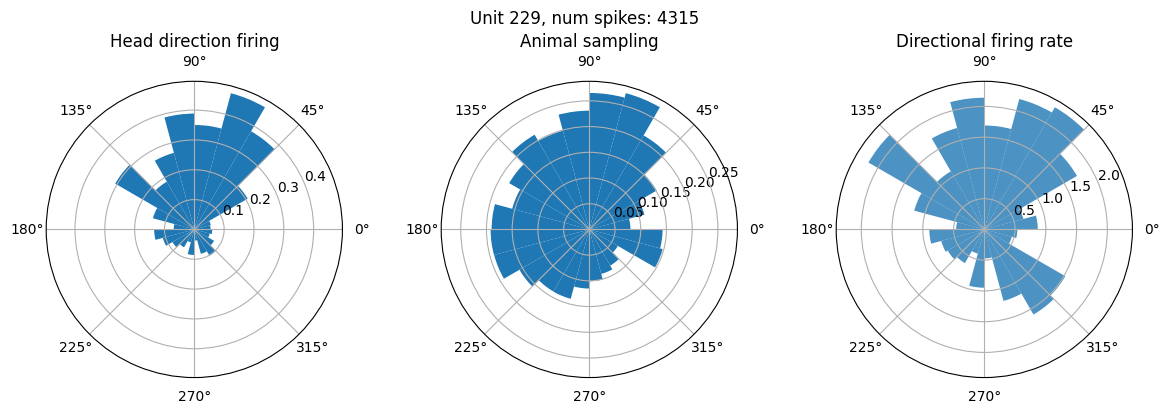

In [9]:
# 3 plots:
# Left: HD per bin
# Middle: Total spike count per HD:
# Right: Total sampling
from numpy import random
unit_id = random.randint(300)
unit_id = 229
num_bins = 64
bin_size = 1400/num_bins


xy_hd_trial = pd.read_csv(r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\XY_HD_alltrials.csv")         
xy = xy_hd_trial.iloc[:, :2].to_numpy().T
x = xy_hd_trial.iloc[:, 0].to_numpy()
y = xy_hd_trial.iloc[:, 1].to_numpy()
hd = xy_hd_trial.iloc[:, 2].to_numpy()
sync = np.arange(len(x))

# Loading data
spike_train_unscaled = sorting.get_unit_spike_train(unit_id=unit_id)
spike_train = np.int32(spike_train_unscaled*frame_rate/sample_rate) # trial data is now in frames in order to match it with xy data
spike_train_org = np.copy(spike_train)


hd_rad = np.deg2rad(hd)
fig, ax = plt.subplots(1, 3, figsize = (12,4), subplot_kw = {'projection': 'polar'})
fig.suptitle(f"Unit {unit_id}, num spikes: {len(spike_train)}")
headdir_bin_centers, firing_rate, headdir_occupancy = calculate_firing_rate_by_headdir(hd, spike_train, sync)
headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)
width = 2 * np.pi / len(headdir_bin_centers_rad)  # width of each bar (in radians)

headdir_bin_centers_rad = np.deg2rad(headdir_bin_centers)   # Your bin centers, in radians

width = np.diff(headdir_bin_centers_rad)[0]
counter = 0
firing_rate[np.isnan(firing_rate)] = 0



# Total spikecount per hd
hd_count = hd[spike_train]
hd_rad_count = np.deg2rad(hd_count)
_, _, _ = ax[0].hist(hd_rad_count, bins = 24, density = True)
ax[0].set_title('Head direction firing')
# Total sampling for the day
n, bins, _= ax[1].hist(hd_rad, bins = 24, density = True)
ax[1].set_title('Animal sampling')

bars = ax[2].bar(
    headdir_bin_centers_rad,
    firing_rate,
    width=width,
    bottom=0.0,
    alpha=0.8
)
ax[2].set_title('Directional firing rate')
plt.tight_layout()
plt.show()

In [23]:
n_bins = 24

hd_nonan = hd_rad[~np.isnan(hd_rad)]
occupancy_counts, _ = np.histogram(hd_rad, bins=n_bins, range = [-np.pi, np.pi])
occupancy_time = occupancy_counts / frame_rate 

hd_rad_count = hd_rad_count[~np.isnan(hd_rad_count)]
counts, bin_edges = np.histogram(hd_rad_count, bins=n_bins,range = [-np.pi, np.pi] )
bin_idx = np.digitize(hd_rad_count, bin_edges) - 1  # zero-based index for Python

direction_firing_rate = np.divide(counts, occupancy_time, out=np.full_like(counts, np.nan, dtype=float), where=occupancy_time!=0)
#bin_idx = np.clip(bin_idx, 0, len(direction_firing_rate) - 1)

W = direction_firing_rate[bin_idx]

# 6. Circular statistics
MRL = resultant_vector_length(hd_rad_count, w=W)
mu = circmean(hd_rad_count, weights=W)
mean_angle_deg = np.rad2deg(mu)
print(MRL, mean_angle_deg)

0.6220441782024778 86.32322434936725


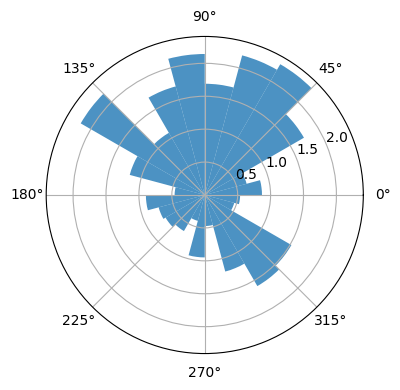

In [22]:
fig, ax = plt.subplots(1, 1, figsize = (12,4), subplot_kw = {'projection': 'polar'})


bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = np.diff(bin_centers)[0]
plt.bar(
    bin_centers,
    direction_firing_rate,
    width=width,
    bottom=0.0,
    alpha=0.8
)
plt.tight_layout()
plt.show()

In [16]:
print(MRL)

0.6104916730599295
